In [6]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

### Read processed data

In [8]:
dftrain = pd.read_csv('../data/cleaned_train.csv')
dftest = pd.read_csv('../data/cleaned_test.csv')

#### Remove zero-important features

In [370]:
ytrain = np.log1p(target.values)
xtrain, xval, ytrain, yval = train_test_split(dftrain_final, ytrain, test_size = 0.2, random_state = 2018)

In [371]:
mmsx = StandardScaler().fit(xtrain)
xtrain_scaled = mmsx.transform(xtrain)
xval_scaled = mmsx.transform(xval)

In [372]:
from sklearn.ensemble import RandomForestRegressor

rfparams = {}
rfparams['n_estimators'] = 22
rfparams['max_depth'] = 120
rfparams['min_samples_split'] = 25
rfparams['min_samples_leaf'] = 5
rfparams['n_jobs'] = -1
rfparams['random_state'] = 2018

rfmodel = RandomForestRegressor(**rfparams)

In [373]:
rfmodel.fit(xtrain_scaled, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=120,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=25,
           min_weight_fraction_leaf=0.0, n_estimators=22, n_jobs=-1,
           oob_score=False, random_state=2018, verbose=0, warm_start=False)

In [374]:
predval = rfmodel.predict(xval_scaled)
mean_squared_error(yval, predval)

2.095404746436861

In [378]:
imp_features = pd.DataFrame(np.column_stack(
                            [list(dftrain_final.columns), list(rfmodel.feature_importances_)]), 
                            columns = ['feature', 'importance'])

In [379]:
imp_features.importance = imp_features.importance.astype(float)

In [380]:
imp_features.sort_values('importance', ascending= False).head(10)

,feature,importance
881,f190486d6,0.101340
742,eeb9cd3aa,0.037169
509,58e2e02e6,0.034751
858,15ace8c9f,0.028317
564,9fd594eec,0.020217
762,58232a6fb,0.014465
0,20aa07010,0.013499
794,d6bb78916,0.010450
294,024c577b9,0.009687
167,6eef030c1,0.009442


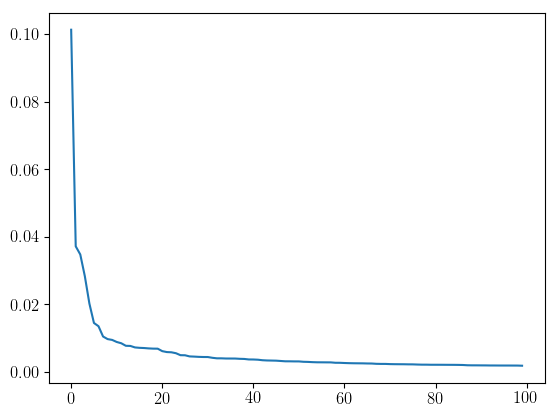

In [381]:
plt.plot(list(imp_features.sort_values('importance', ascending= False).head(100)['importance']))
plt.show()

In [281]:
pd.merge(dftrain.f190486d6.describe().to_frame('train').reset_index(),
         dftest.f190486d6.describe().to_frame('test').reset_index(),
         on = 'index',
         how = 'outer')

,index,train,test
0,count,4.459000e+03,4.934200e+04
1,mean,2.565014e+06,1.460995e+06
2,std,8.906709e+06,6.730017e+06
3,min,0.000000e+00,0.000000e+00
4,25%,0.000000e+00,0.000000e+00
5,50%,0.000000e+00,0.000000e+00
6,75%,7.165000e+05,0.000000e+00
7,max,3.196120e+08,2.000000e+08


In [382]:
non_important_features = imp_features[imp_features.importance == 0.0]['feature'].tolist()

In [347]:
dftrain_final = dftrain.drop(non_important_features, axis =1)

In [348]:
dftest_final = dftest.drop(non_important_features, axis =1)

In [350]:
print(dftrain_final.shape, dftest_final.shape)

(4459, 1031) (49342, 1031)


## Model building

#### Single model

In [5]:
import lightgbm as lgb

OSError: dlopen(/usr/local/lib/python3.6/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/gcc/lib/gcc/7/libgomp.1.dylib
  Referenced from: /usr/local/lib/python3.6/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [484]:
ytrain = np.log1p(target.values)
xtrain = dftrain

In [485]:
mms = StandardScaler().fit(xtrain)
xtrain_scaled = mms.transform(xtrain)
xval_scaled = mms.transform(xval)

#### Ensemble model

In [511]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

def r2score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return r2_score(y_true, y_pred)

def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log(y_pred + 1) - np.log(y_true + 1), 2)))

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(KFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_valid = X[valid_idx]
                y_valid = y[valid_idx]
                clf.fit(X_train, y_train)
                valid_pred = clf.predict(X_valid)
                S_train[valid_idx, i] = valid_pred
                S_test_i[:, j] = clf.predict(T)
                
                print('Model: {}, fold: {}, rmsle: {}'.format(i, j, 1 - r2score(y_valid, valid_pred)))
            print( "\nTraining RMSLE for model {} : {}".format(i, 1 - r2score(y, S_train[:,i])))
            S_test[:, i] = S_test_i.mean(axis=1)
            
        return S_train, S_test

In [ ]:
# LightGBM params# LightG 
lgb_params = {}
lgb_params['learning_rate'] = 0.75
lgb_params['n_estimators'] = 200
lgb_params['max_depth'] = 60
lgb_params['num_leaves'] = 50
lgb_params['n_jobs'] = 4
lgb_params['random_state'] = 2018

lgb_model = lgb.LGBMRegressor(**lgb_params)


In [513]:
ensemble = Create_ensemble(n_splits = 5, base_models = [lgb_model])
X = xtrain
Y = ytrain
T = dftest
train_pred, test_pred = ensemble.predict(X, Y, T)

Model: 0, fold: 0, rmsle: 0.1305042686551112
Model: 0, fold: 1, rmsle: 0.12508295040763948
Model: 0, fold: 2, rmsle: 0.12631139119161983
Model: 0, fold: 3, rmsle: 0.12050241203995365
Model: 0, fold: 4, rmsle: 0.12550095555345667

Training RMSLE for model 0 : 0.12562088288152826


In [514]:
np.shape(test_pred)

(49342, 1)

In [517]:
np.expm1(train_pred[0:10])

array([[3813826.62426682],
       [ 560153.58879875],
       [1482848.94967502],
       [1450984.93940809],
       [1145978.62131449],
       [1327748.56249655],
       [ 103361.53786863],
       [1035170.42913511],
       [4175839.00230866],
       [4940343.74296744]])

In [ ]:
length = 20

pd.DataFrame(np.column_stack(
                        [np.expm1(test_pred[0:length]), 
                         np.expm1(train_pred[0:length]), 
                         np.absolute(np.expm1(test_pred[0:length]) - np.expm1(train_pred[0:length]))], 
             columns = ['predictions', 'validations', 'difference']))

### Submission

In [361]:
sub = pd.read_csv('../data/sample_submission.csv')

In [362]:
sub["target"] = pred_test

In [364]:
sub.to_csv('submission_with_removed_features.csv', index=False)